In [2]:
#import packages
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#np.random.seed(12345)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [3]:
data = 'DATA/data_t-SNE_310101_d5_R100_e1_N800.dat'
columns=['x1','x2','x3','x4','x5']

#df_raw will not contain labels
df_raw = pd.read_csv(data, delimiter='\t',header=None, names=columns)
N=len(df_raw)

df = df_raw.copy(deep=True)

label0 = np.full(int(N*0.1),0)
label1 = np.full(int(N*0.3),1)
label2 = np.full(int(N*0.6),2)
label = np.concatenate([label0,label1,label2])

#df will also contain labels
df['label'] = label

In [ ]:
df.head(5)

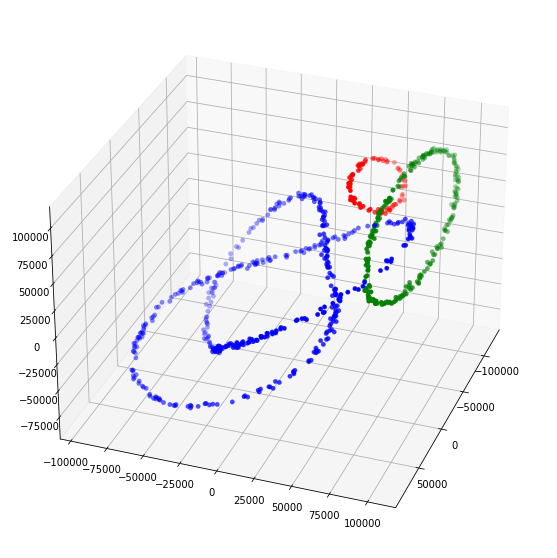

In [53]:
fig = plt.figure(figsize=(15,10))

red = df['label'] == 0
green = df['label'] == 1
blue = df['label'] == 2

ax = fig.gca(projection='3d')
ax.scatter(df[red]['x1'], df[red]['x2'], df[red]['x3'], c='red', linewidth=0.2)
ax.scatter(df[green]['x1'], df[green]['x2'], df[green]['x3'], c='green', linewidth=0.2)
ax.scatter(df[blue]['x1'], df[blue]['x2'], df[blue]['x3'], c='blue', linewidth=0.2)
ax.view_init(30, 20)
plt.show()
#funzia

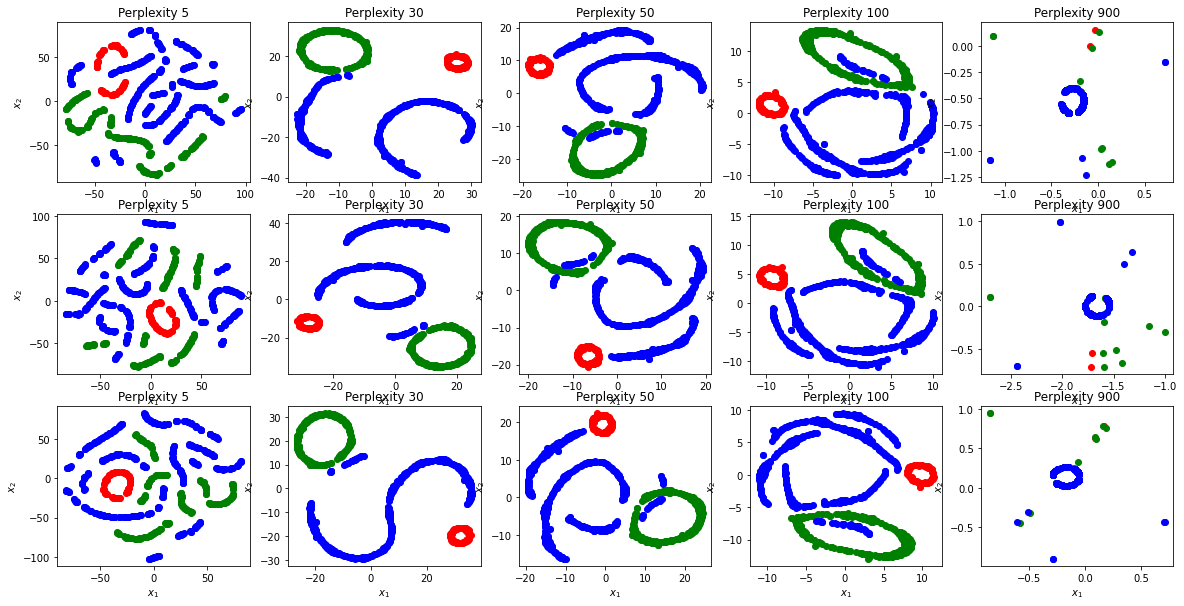

In [54]:
fig, ax = plt.subplots(3,5, figsize=(20,10))
perplexity_list = [5,30,50,100,900]

for i in range(3):
    for j in range(len(perplexity_list)):
        X_embedded = TSNE(n_components=2,  perplexity=perplexity_list[j]).fit_transform(df)
        x = np.array([X_embedded[j][0] for j in range(X_embedded.shape[0])] )
        y = np.array([X_embedded[j][1] for j in range(X_embedded.shape[0])] )
        ax[i][j].set_title(f'Perplexity {perplexity_list[j]}')
        ax[i][j].set_xlabel('$x_1$')
        ax[i][j].set_ylabel('$x_2$')
        ax[i][j].scatter(x[red],y[red], color = 'red')
        ax[i][j].scatter(x[green],y[green], color = 'green')
        ax[i][j].scatter(x[blue],y[blue], color = 'blue')

plt.show()

In [97]:
X_embedded = TSNE(n_components=2,  perplexity=30).fit_transform(df)
print(X_embedded.shape)

(800, 2)


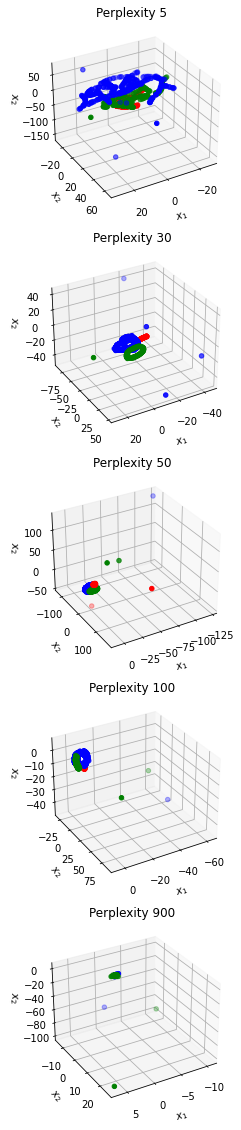

In [55]:
fig = plt.figure(figsize=(20,20))

for i in range(len(perplexity_list)):
    ax   = fig.add_subplot(len(perplexity_list), 1, i+1, projection='3d')
    X_embedded = TSNE(n_components=3, perplexity=perplexity_list[i]).fit_transform(df)
    x = np.array([X_embedded[j][0] for j in range(X_embedded.shape[0])] )
    y = np.array([X_embedded[j][1] for j in range(X_embedded.shape[0])] )
    z = np.array([X_embedded[j][2] for j in range(X_embedded.shape[0])] )
    ax.set_title(f'Perplexity {perplexity_list[i]}')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_2$')
    ax.scatter(x[red],y[red],z[red], color = 'red')
    ax.scatter(x[green],y[green],z[green], color = 'green')
    ax.scatter(x[blue],y[blue],z[blue], color = 'blue')
    ax.view_init(30, 60)
        
plt.show()

## Optimal EPS calculation

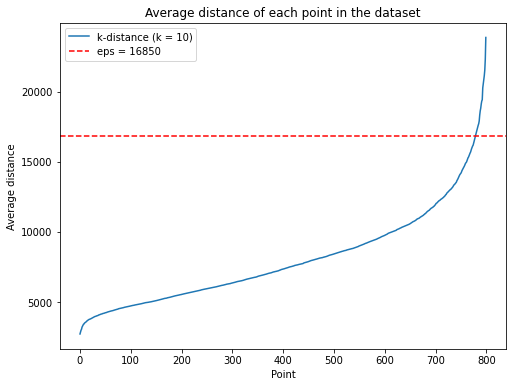

In [139]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(8,6))
def find_slope(dist, pct = 0.01):
    flag = 0
    epsilon = 0
    for i in range(200,len(dist)):
        if flag == 0: 
            if dist[i+1]/dist[i] > (1+pct):
                epsilon = (dist[i]+dist[i+1])/2.
                flag = 1 
    return epsilon

dataset = df_raw.copy()
#NN grande e di quelli istogrammma delle distanze -> picco = eps
neighbors = NearestNeighbors(n_neighbors=11)
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)
#ordering distances from smaller to higher
distances = np.sort(distances, axis=0)
#removing the distance from the point to itself
distances = distances[:,1:]
#taking the average, if not, eps will be underestimated
distances = distances.mean(axis=1)
eps = find_slope(distances,.01)

plt.plot(distances, label = 'k-distance (k = 10)')
plt.title('Average distance of each point in the dataset')
plt.xlabel('Point')
plt.ylabel('Average distance')
plt.axhline(eps, c='r', ls = '--', label = 'eps = {}'.format(int(eps)))
plt.legend()
plt.show()

## Prova con diversi n_neighbours

In [ ]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(8,6))
def find_slope(dist, pct = 0.01):
    flag = 0
    epsilon = 0
    for i in range(200,len(dist)):
        if flag == 0: 
            if dist[i+1]/dist[i] > (1+pct):
                epsilon = (dist[i]+dist[i+1])/2.
                flag = 1 
    return epsilon

dataset = df_raw.copy()
n_neighbours=np.arange(2,15,1)
for i in range(len(n_neighbours)):
    neighbors = NearestNeighbors(n_neighbors=n_neighbours[i])
    neighbors_fit = neighbors.fit(dataset)
    distances, indices = neighbors_fit.kneighbors(dataset)
    #ordering distances from smaller to higher
    distances = np.sort(distances, axis=0)
    #removing the distance from the point to itself
    distances = distances[:,1:]
    #taking the average, if not, eps will be underestimated
    distances = distances.max(axis=1)
    #print(n_neighbours[i])
    eps = find_slope(distances,.01)

    plt.plot(distances, label = f'k-distance (k = {n_neighbours[i]})')
plt.title('Average distance of each point in the dataset')
plt.xlabel('Point')
plt.ylabel('Average distance')
plt.axhline(eps, c='r', ls = '--', label = 'eps = {}'.format(int(eps)))
plt.legend()
plt.show()

In [128]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

X = df_raw.to_numpy()
y_true = df['label']

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

# Normalized mutual information function
# Note that this deals with the label permutation problem

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

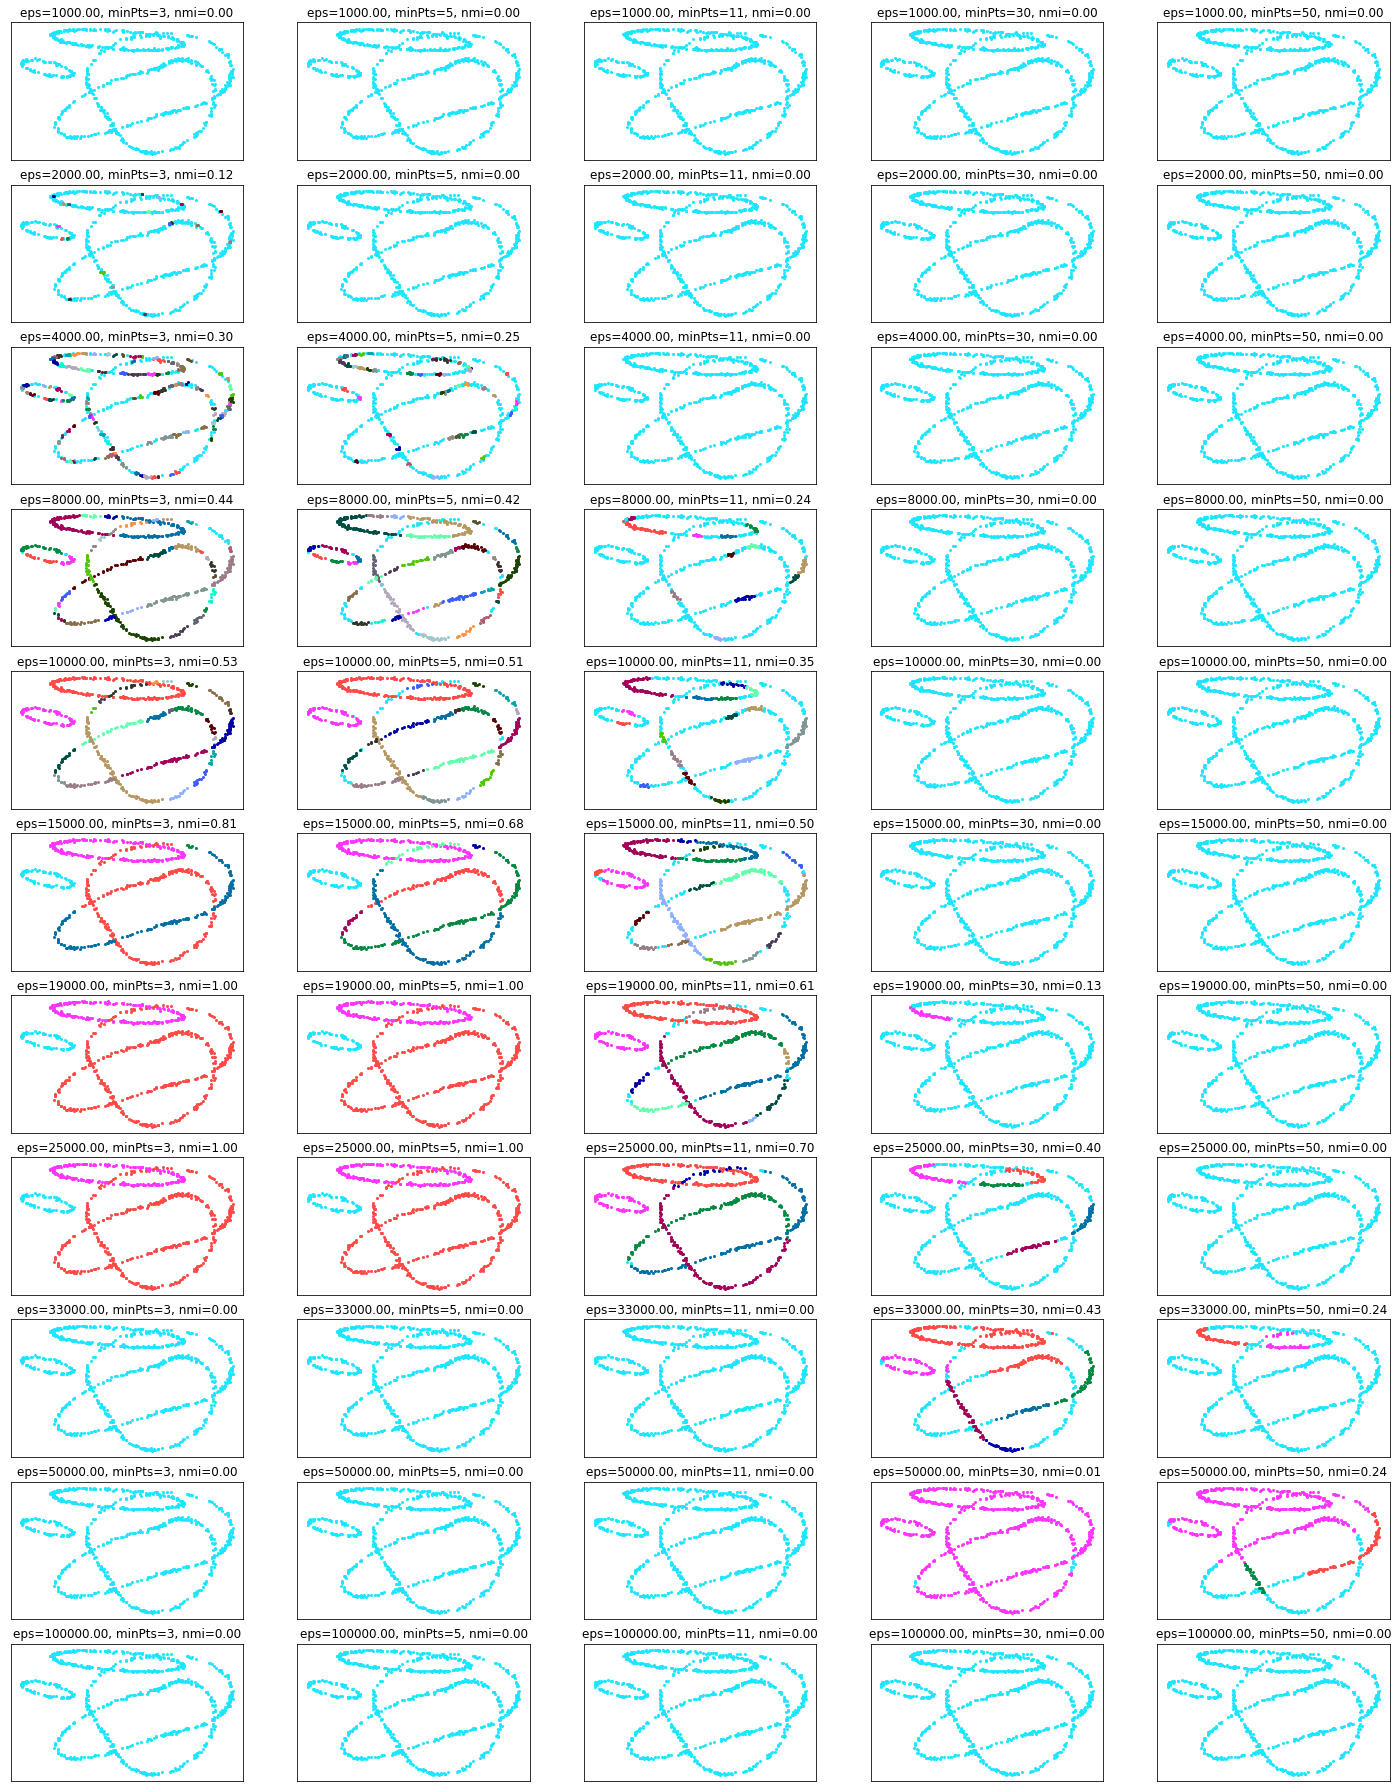

In [140]:
eps_range = [1000,2000,4000,8000,10000, 15000, 19000, 25000, 33000, 50000, 100000]
min_sample_range = [3,5,11,30,50]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(20,25))
n_labels_for_method = []
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        #keeping track on the number of labels for each method
        n_labels_for_method.append(list(set(y)))
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        ax[i,j].get_xaxis().set_ticks([])
        ax[i,j].get_yaxis().set_ticks([])
plt.tight_layout(h_pad=0.5)
plt.show()

devo printare eps vs n labels

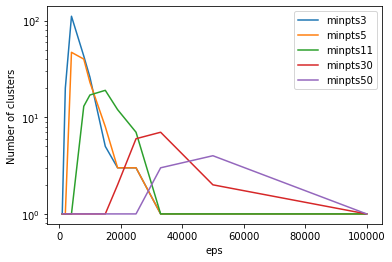

In [130]:
minPts3 = n_labels_for_method[::5]
minPts5 = n_labels_for_method[1::5]
minPts11 = n_labels_for_method[2::5]
minPts30 = n_labels_for_method[3::5]
minPts50 = n_labels_for_method[4::5]

minPts3_y = []
minPts5_y = []
minPts11_y = []
minPts30_y = []
minPts50_y = []

for i in range(len(eps_range)):
    minPts3_y.append(len(minPts3[i]))
    minPts5_y.append(len(minPts5[i]))
    minPts11_y.append(len(minPts11[i]))
    minPts30_y.append(len(minPts30[i]))
    minPts50_y.append(len(minPts50[i]))

plt.plot(eps_range,minPts3_y, label='minpts3')
plt.plot(eps_range,minPts5_y, label='minpts5')
plt.plot(eps_range,minPts11_y, label='minpts11')
plt.plot(eps_range,minPts30_y, label='minpts30')
plt.plot(eps_range,minPts50_y, label='minpts50')
plt.xlabel('eps')
plt.ylabel('Number of clusters')
plt.yscale('log')
plt.legend()
plt.show()

## Prova con un arange su eps 

In [142]:
from tqdm import tqdm
#da fare con un linspace
eps_range = np.arange(1000,100000,100)
print(eps_range)
#eps_range = [1000,2000,4000,8000,10000, 15000, 16850, 25000, 30000, 50000, 100000]
min_sample_range = [3,5,11,30,50]
n_labels_for_method = []
for i, eps in tqdm(enumerate(eps_range)):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        #keeping track on the number of labels for each method
        n_labels_for_method.append(list(set(y)))


4it [00:00, 35.31it/s]

[ 1000  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100
  2200  2300  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300
  3400  3500  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500
  4600  4700  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700
  5800  5900  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900
  7000  7100  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100
  8200  8300  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300
  9400  9500  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500
 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700
 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900
 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100
 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300
 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500
 16600 16700 16800 16900 17000 17100 17200 17300 17

990it [00:39, 24.92it/s]


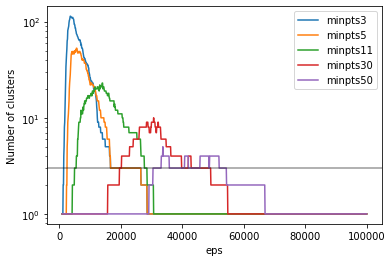

In [143]:
minPts3 = n_labels_for_method[::5]
minPts5 = n_labels_for_method[1::5]
minPts11 = n_labels_for_method[2::5]
minPts30 = n_labels_for_method[3::5]
minPts50 = n_labels_for_method[4::5]

minPts3_y = []
minPts5_y = []
minPts11_y = []
minPts30_y = []
minPts50_y = []

for i in range(len(eps_range)):
    minPts3_y.append(len(minPts3[i]))
    minPts5_y.append(len(minPts5[i]))
    minPts11_y.append(len(minPts11[i]))
    minPts30_y.append(len(minPts30[i]))
    minPts50_y.append(len(minPts50[i]))

plt.plot(eps_range,minPts3_y, label='minpts3')
plt.plot(eps_range,minPts5_y, label='minpts5')
plt.plot(eps_range,minPts11_y, label='minpts11')
plt.plot(eps_range,minPts30_y, label='minpts30')
plt.plot(eps_range,minPts50_y, label='minpts50')
plt.xlabel('eps')
plt.ylabel('Number of clusters')
plt.yscale('log')
plt.legend()
#plt.xlim(28000,30000)
plt.axhline(y=3, c='black',alpha=0.4)

plt.show()